# Lab Seven for UW AMATH 563
## Assignment: Applications and Extensions of RNNs
## By Rebecca Lopez

In this assignment, we use recurrent neural networks on stock data, specifically open values, to predict future values.

In [1]:
#Import Necessary Packages & Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
from torchvision import transforms
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

#Set Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
#Comment out lines below if not using google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Import data
tesla_stocks = pd.read_csv('/content/drive/My Drive/Colab Notebooks/TSLA.csv')
google_stocks = pd.read_csv('/content/drive/My Drive/Colab Notebooks/GOOGL.csv')
dow_stocks = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DJI.csv')

In [4]:
#Define our data sets
data_tesla = tesla_stocks['Open'].values
data_google = google_stocks['Open'].values
data_dow = tesla_stocks['Open'].values

In [5]:
#Normalize data
scaler = StandardScaler()
data_tesla = scaler.fit_transform(data_tesla.reshape(-1, 1))
data_google = scaler.fit_transform(data_google.reshape(-1, 1))
data_dow = scaler.fit_transform(data_dow.reshape(-1, 1))

In [6]:
#Define window function for sliding input
class SlidingInput(torch.utils.data.Dataset):
    def __init__(self, open_value, input_window):
        self.open_value = torch.tensor(open_value).float()
        self.input_window = input_window 

    def __len__(self):
        return len(self.open_value) - self.input_window 
    
    def __getitem__(self, idx):
        return self.open_value[idx:idx+input_window], self.open_value[idx+input_window]

In [7]:
#Amount of input to be taken in a window 
input_window = 25

#Tesla
telsa_train_set = SlidingInput(data_tesla[:-100-input_window], input_window)
telsa_train_set, telsa_val_set = torch.utils.data.random_split(telsa_train_set, [int(len(telsa_train_set)*0.9)+1, int(len(telsa_train_set)*0.1)])
telsa_val_loader = torch.utils.data.DataLoader(telsa_val_set, batch_size=len(telsa_val_set), shuffle=True)

#Google
google_train_set = SlidingInput(data_google[:-100-input_window], input_window)
google_train_set, google_val_set = torch.utils.data.random_split(google_train_set, [int(len(google_train_set)*0.9)+1, int(len(google_train_set)*0.1)])
google_val_loader = torch.utils.data.DataLoader(google_val_set, batch_size=len(google_val_set), shuffle=True)

#Dow Jones
dow_train_set = SlidingInput(data_dow[:-100-input_window], input_window)
dow_train_set, dow_val_set = torch.utils.data.random_split(dow_train_set, [int(len(dow_train_set)*0.9)+1, int(len(dow_train_set)*0.1)])
dow_val_loader = torch.utils.data.DataLoader(dow_val_set, batch_size=len(dow_val_set), shuffle=True)

## RNN Model Definitions

In [8]:
#Vanilla RNN
class VanillaRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(VanillaRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.RNN(input_dim,hidden_dim, layer_dim,batch_first=True)
        self.fc = nn.Linear(hidden_dim,output_dim)
    
    def forward(self,x):
        h0 = torch.zeros(self.layer_dim, x.size(0),self.hidden_dim).requires_grad_().cuda()
        out, h0 =self.rnn(x,h0.detach())
        out = self.fc(out[:,-1,:])
        return out
    
#Gated Recurrent Unit RNN
class GRURNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(GRURNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.gru = nn.GRU(input_dim,hidden_dim, layer_dim,batch_first=True)
        self.fc = nn.Linear(hidden_dim,output_dim)
    
    def forward(self,x):
        h0 = torch.zeros(self.layer_dim, x.size(0),self.hidden_dim).requires_grad_().cuda()
        out, hn =self.gru(x,h0)
        out = self.fc(out[:,-1,:])
        return out
    
#Long Short Term Memory RNN
class LSTMRNN(nn.Module):
    def __init__(self, input_dim,hidden_dim,layer_dim,output_dim):
        super(LSTMRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim,hidden_dim, layer_dim,batch_first=True)
        self.fc = nn.Linear(hidden_dim,output_dim)
    
    def forward(self,x):
        h0 = torch.zeros(self.layer_dim, x.size(0),self.hidden_dim).requires_grad_().cuda()
        c0 = torch.zeros(self.layer_dim, x.size(0),self.hidden_dim).requires_grad_().cuda()
        out, (hn,cn) =self.lstm(x,(h0,c0))
        out = self.fc(out[:,-1,:])
        return out



## Training code: Vanilla RNN for Telsa

In [37]:
#Define hyperparameters
epochs = 600
output_dim = 1
input_dim = 1
hidden_dim = 512
layer_dim = 2
batch_size = 32


telsa_train_loader = torch.utils.data.DataLoader(telsa_train_set, batch_size=batch_size, shuffle=True)
model = VanillaRNN(input_dim, hidden_dim, layer_dim, output_dim).to(device)
print(next(model.parameters()).is_cuda)

#Define Loss function
criterion = nn.MSELoss()
#Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_list = []

#Train Model
for epoch in range(epochs):
    for batch,target in telsa_train_loader:
        batch= batch.cuda()
        target= target.cuda()
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())

    if epoch%100 == 0:
        print(f"i {epoch}, loss {loss.data:.4f}")

  

True
i 0, loss 0.0030
i 100, loss 0.0059
i 200, loss 0.0045
i 300, loss 0.0025
i 400, loss 0.0139
i 500, loss 0.0109


In [ ]:
model_prediction = []

actual_values = scaler.inverse_transform(data_tesla[-100:]).reshape(-1,1)
input = torch.tensor(data_tesla[-100-input_window:-100])
input = input.float()
input = input.cuda()

#Test Model
for i in range(100):
    output = model(input.reshape(1, -1, 1))
    predication = output.item()

    model_prediction.append(scaler.inverse_transform(np.array(predication).reshape(-1,1)))
    input[:-1] = input[1:].clone()
    input[-1] = predication

model_prediction= np.array(model_prediction).flatten().tolist()

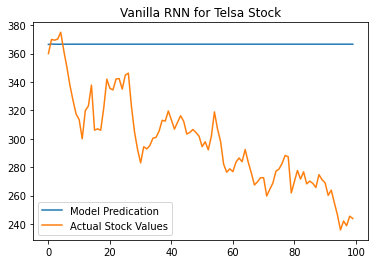

In [38]:
#Produce plot of model predication versus the actual stock values
plt.plot(model_prediction, label='Model Predication')
plt.plot(actual_values, label='Actual Stock Values')
plt.title('Vanilla RNN for Telsa Stock')
plt.legend()
plt.show()

## Training code: GRU RNN for Google


In [40]:
#Define hyperparameters
epochs = 600
output_dim = 1
input_dim = 1
hidden_dim = 512
layer_dim = 2
batch_size = 32


google_train_loader = torch.utils.data.DataLoader(google_train_set, batch_size=batch_size, shuffle=True)
model = GRURNN(input_dim, hidden_dim, layer_dim, output_dim).to(device)
print(next(model.parameters()).is_cuda)

#Define Loss function
criterion = nn.MSELoss()
#Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_list = []

#Train Model
for epoch in range(epochs):
    for batch,target in google_train_loader:
        batch= batch.cuda()
        target= target.cuda()
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())

    if epoch%100 == 0:
        print(f"i {epoch}, loss {loss.data:.4f}")

  

True
i 0, loss 0.0021
i 100, loss 0.0016
i 200, loss 0.0012
i 300, loss 0.0002
i 400, loss 0.0002
i 500, loss 0.0000


In [ ]:
model_prediction = []
actual_values = scaler.inverse_transform(data_google[-100:]).reshape(-1,1)
input = torch.tensor(data_google[-100-input_window:-100])
input = input.float()
input = input.cuda()

#Test Model
for i in range(100):
    output = model(input.reshape(1, -1, 1))
    predication = output.item()

    model_prediction.append(scaler.inverse_transform(np.array(predication).reshape(-1,1)))
    input[:-1] = input[1:].clone()
    input[-1] = predication

model_prediction= np.array(model_prediction).flatten().tolist()

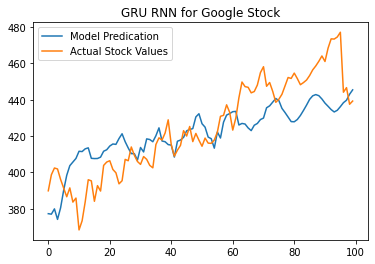

In [41]:
#Produce plot of model predication versus the actual stock values
plt.plot(model_prediction, label='Model Predication')
plt.plot(actual_values, label='Actual Stock Values')
plt.title('GRU RNN for Google Stock')
plt.legend()
plt.show()

## Training code: LSMT RNN for Dow Jones

In [42]:
#Define hyperparameters
epochs = 600
output_dim = 1
input_dim = 1
hidden_dim = 512
layer_dim = 2
batch_size = 32


dow_train_loader = torch.utils.data.DataLoader(dow_train_set, batch_size=batch_size, shuffle=True)
model = LSTMRNN(input_dim, hidden_dim, layer_dim, output_dim).to(device)
print(next(model.parameters()).is_cuda)

#Define Loss function
criterion = nn.MSELoss()
#Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_list = []

#Train Model
for epoch in range(epochs):
    for batch,target in dow_train_loader:
        batch= batch.cuda()
        target= target.cuda()
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())

    if epoch%100 == 0:
        print(f"i {epoch}, loss {loss.data:.4f}")

  

True
i 0, loss 0.0043
i 100, loss 0.0009
i 200, loss 0.0010
i 300, loss 0.0019
i 400, loss 0.0009
i 500, loss 0.0001


In [ ]:
model_prediction = []
actual_values = scaler.inverse_transform(data_dow[-100:]).reshape(-1,1)
input = torch.tensor(data_dow[-100-input_window:-100])
input = input.float()
input = input.cuda()

#Test Model
for i in range(100):
    output = model(input.reshape(1, -1, 1))
    predication = output.item()

    model_prediction.append(scaler.inverse_transform(np.array(predication).reshape(-1,1)))
    input[:-1] = input[1:].clone()
    input[-1] = predication

model_prediction= np.array(model_prediction).flatten().tolist()

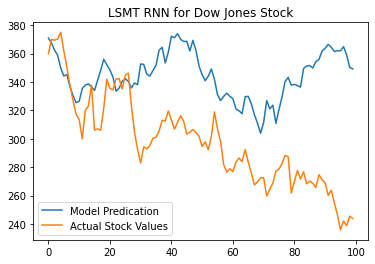

In [43]:
#Produce plot of model predication versus the actual stock values
plt.plot(model_prediction, label='Model Predication')
plt.plot(actual_values, label='Actual Stock Values')
plt.title('LSMT RNN for Dow Jones Stock')
plt.legend()
plt.show()